Probabilidad de tránsito para TIC_307210830: 100.00%


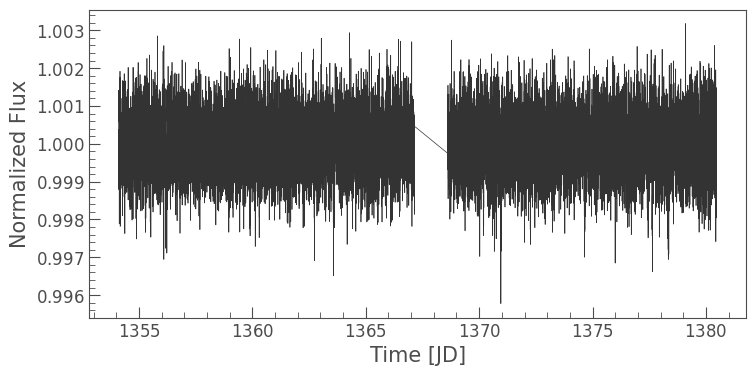

In [5]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightkurve import LightCurve

# ---------- CONFIGURACIÓN ----------
MODEL_PATH = "../models/transit_cnn.pt"
META_PATH = "../models/transit_cnn_meta.json"
DATA_DIR = "../data"
target = "TIC_307210830"  # podés cambiar esto por otro CSV que tengas

# ---------- DEFINICIÓN DEL MODELO ----------
class TransitCNN(torch.nn.Module):
    def __init__(self, input_length):
        super(TransitCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(1, 8, kernel_size=5)
        self.pool = torch.nn.MaxPool1d(2)
        conv_out_size = (input_length - 4) // 2
        self.fc1 = torch.nn.Linear(8 * conv_out_size, 64)
        self.fc2 = torch.nn.Linear(64, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# ---------- CARGAR METADATOS ----------
with open(META_PATH, "r") as f:
    meta = json.load(f)

INPUT_LENGTH = meta["input_length"]

# ---------- CARGAR MODELO ----------
model = TransitCNN(INPUT_LENGTH)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# ---------- CARGAR CURVA ----------
df = pd.read_csv(os.path.join(DATA_DIR, f"{target}.csv"))
lc = LightCurve(time=df["time"], flux=df["flux"])
flattened = lc.flatten(window_length=401)
flux = flattened.flux.value

# Normalizar longitud
if len(flux) < INPUT_LENGTH:
    flux = np.pad(flux, (0, INPUT_LENGTH - len(flux)), mode="constant", constant_values=0)
else:
    flux = flux[:INPUT_LENGTH]

X = np.array([flux], dtype=np.float32)[:, np.newaxis, :]
X_tensor = torch.tensor(X)

# ---------- PREDICCIÓN ----------
with torch.no_grad():
    prediction = model(X_tensor)
    prob = prediction.item()

# ---------- RESULTADO ----------
print(f"Probabilidad de tránsito para {target}: {prob:.2%}")

# ---------- VISUALIZACIÓN ----------
flattened.plot(title=f"Curva de luz ({target}) - Probabilidad de tránsito: {prob:.2%}")
plt.show()
